In [1]:
#importing stuff
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import shap
#sns.set(style = "darkgrid")

c:\Users\cnels\Desktop\stat386\Final_Movie_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#loading the dataset
df = pd.read_csv("movie_data.csv")

#getting data summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Title                                193 non-null    object 
 1   Release Date                         193 non-null    object 
 2   Inflation Adjusted Domestic Revenue  184 non-null    float64
 3   Domestic Revenue                     184 non-null    float64
 4   International Revenue                186 non-null    float64
 5   Total Box Office Revenue             186 non-null    float64
 6   Domestic Video Revenue               157 non-null    float64
 7   Opening Weekend                      184 non-null    float64
 8   Production Budget                    155 non-null    float64
 9   Theater Number                       184 non-null    float64
 10  MPAA Rating                          191 non-null    object 
 11  Runtime                         

In [3]:
#Deal with NaN Values
#Using the median to impute most of the values, except for month, which is mode.

#dropping rows without target
df_ml = df.dropna(subset=["Total Box Office Revenue"])
#dropping text columns we can't use
df_ml = df_ml.drop(columns=[
    "Title", "Season", "MPAA Rating", "Genre", "Franchise", "Production Method"
])
#dropping the time-data columns since we have month and year of film release separated
df_ml = df_ml.drop(columns=[
    "Release Date", "Video Release Date"
])
#filling in with median
num_cols = [
    "Inflation Adjusted Domestic Revenue", "Domestic Revenue",
    "International Revenue", "Domestic Video Revenue",
    "Opening Weekend", "Production Budget", "Theater Number",
    "Runtime", "Domestic DVD Revenue", "Domestic Bluray Revenue",
    "Year", "Profit"
]
for col in num_cols:
    df_ml[col] = df_ml[col].fillna(df_ml[col].median())
#filling in month with mode
df_ml["Month"] = df_ml["Month"].fillna(df_ml["Month"].mode()[0])
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, 0 to 192
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Inflation Adjusted Domestic Revenue  186 non-null    float64
 1   Domestic Revenue                     186 non-null    float64
 2   International Revenue                186 non-null    float64
 3   Total Box Office Revenue             186 non-null    float64
 4   Domestic Video Revenue               186 non-null    float64
 5   Opening Weekend                      186 non-null    float64
 6   Production Budget                    186 non-null    float64
 7   Theater Number                       186 non-null    float64
 8   Runtime                              186 non-null    float64
 9   Domestic DVD Revenue                 186 non-null    float64
 10  Domestic Bluray Revenue              186 non-null    float64
 11  Month                                

***********************************
Total Box Office Revenue
153733800.0    1
34718173.0     1
86778557.0     1
105632.0       1
57273049.0     1
              ..
77305447.0     1
334560213.0    1
10746915.0     1
757913345.0    1
181805645.0    1
Name: count, Length: 186, dtype: int64


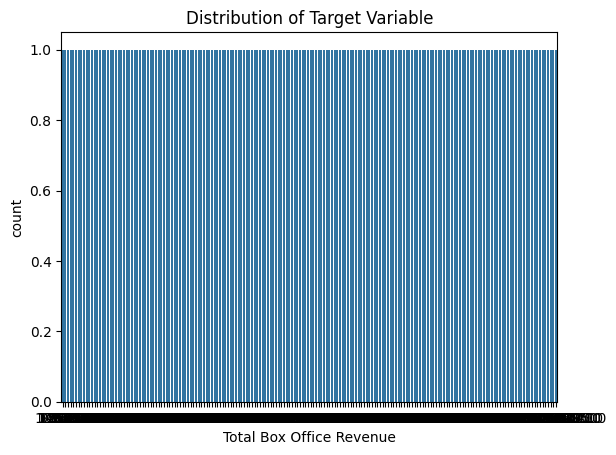

In [4]:
#Checking some stuff
target_counts = df_ml['Total Box Office Revenue'].value_counts()
print("***********************************")
print(target_counts)

# Plot the distribution of the target variable
sns.countplot(x='Total Box Office Revenue', data=df)
plt.title('Distribution of Target Variable')
plt.show()

In [5]:
# Log-transform the target due to skewness of target
df_ml["log_revenue"] = np.log1p(df_ml["Total Box Office Revenue"])

y = df_ml["log_revenue"]
X = df_ml[["Inflation Adjusted Domestic Revenue","Domestic Revenue","International Revenue","Domestic Video Revenue","Opening Weekend","Production Budget","Theater Number","Runtime","Domestic DVD Revenue","Domestic Bluray Revenue","Month","Year","Profit"]]


In [6]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#checking shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (148, 13)
Testing data shape: (38, 13)


In [7]:
#We are going to do three different models and see which one works the best

In [8]:
#Linear Regression Model
# Initialize model
linreg = LinearRegression()

# Train it
linreg.fit(X_train, y_train)

# Predict
y_pred_lin = linreg.predict(X_test)

# Evaluate
print("Linear Regression R²:", r2_score(y_test, y_pred_lin))
print("MAE :", mean_absolute_error(y_test, y_pred_lin))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Linear Regression R²: 0.5563745187550173
MAE : 0.8428374334929701
RMSE : 1.3847123011197684


In [9]:
#Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R²: 0.904920373826034
MAE: 0.24847231134838885
RMSE: 0.6410546301478632


In [10]:
#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("Gradient Boosting R²:", r2_score(y_test, y_pred_gbr))
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))

Gradient Boosting R²: 0.9370799036884707
MAE: 0.22524314098845544
RMSE: 0.5214900156335753


In [11]:
#Model I chose: Gradient Booster Regressor
#This is because it had the largest R2, it explained .43 percent of the variance in the data, making it the best predictor out of the three
#However, I just realized that making a predictive model isn't my goal, it's finding predictive features

In [12]:
#Attempting to find the most important features when predicting
#First getting a Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
#pandas
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False)

International Revenue                  0.736858
Profit                                 0.095236
Domestic Revenue                       0.065598
Inflation Adjusted Domestic Revenue    0.057102
Opening Weekend                        0.011408
Theater Number                         0.007232
Year                                   0.006324
Month                                  0.005595
Domestic DVD Revenue                   0.003857
Runtime                                0.003263
Production Budget                      0.003140
Domestic Bluray Revenue                0.002580
Domestic Video Revenue                 0.001808
dtype: float64

In [14]:
#using sklearn
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)

perm_importances = pd.Series(perm.importances_mean, index=X.columns)
perm_importances.sort_values(ascending=False)

International Revenue                  1.726760
Profit                                 0.071903
Domestic Revenue                       0.054226
Inflation Adjusted Domestic Revenue    0.043017
Opening Weekend                        0.004718
Month                                  0.003958
Theater Number                         0.003225
Year                                   0.002286
Production Budget                      0.002092
Domestic Bluray Revenue                0.001898
Domestic DVD Revenue                   0.001710
Domestic Video Revenue                 0.001318
Runtime                                0.001098
dtype: float64

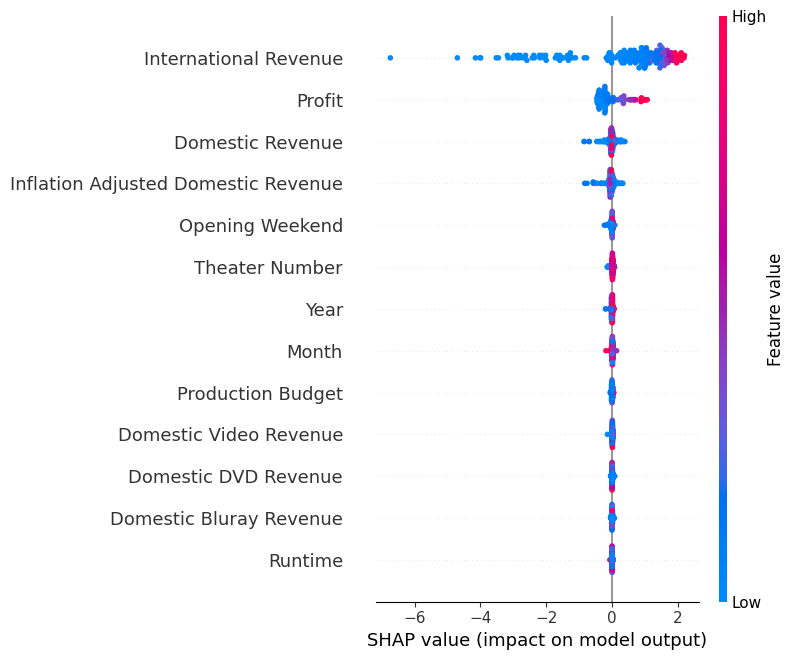

In [15]:
#using shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [16]:
#Trying again, but removing other types of revenue (Now I know that domestic matters the most)
y = df_ml["log_revenue"]
X = df_ml[["Opening Weekend","Production Budget","Theater Number","Runtime","Month","Year"]]

In [17]:
#Doing it again with new labels
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False)

Opening Weekend      0.679353
Theater Number       0.132923
Production Budget    0.058614
Runtime              0.053524
Month                0.045182
Year                 0.030403
dtype: float64

In [19]:
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)
perm_importances.sort_values(ascending=False)

Opening Weekend      1.145087
Theater Number       0.156192
Production Budget    0.057371
Month                0.051710
Runtime              0.047897
Year                 0.031549
dtype: float64

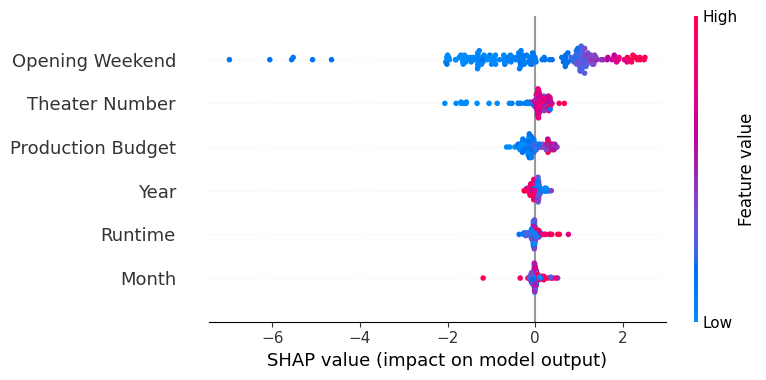

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [21]:
#Now checking it if we don't have the opening weekend, imagine we only have information before it premiers
y = df_ml["log_revenue"]
X = df_ml[["Production Budget","Runtime","Month"]]

In [22]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
rf_importances = pd.Series(model.feature_importances_, index=X.columns)
print(rf_importances.sort_values(ascending=False))

Production Budget    0.524021
Runtime              0.306188
Month                0.169792
dtype: float64


In [24]:
perm = permutation_importance(model, X, y, n_repeats=20, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)
print(perm_importances.sort_values(ascending=False))

Production Budget    1.375690
Runtime              0.418263
Month                0.250395
dtype: float64


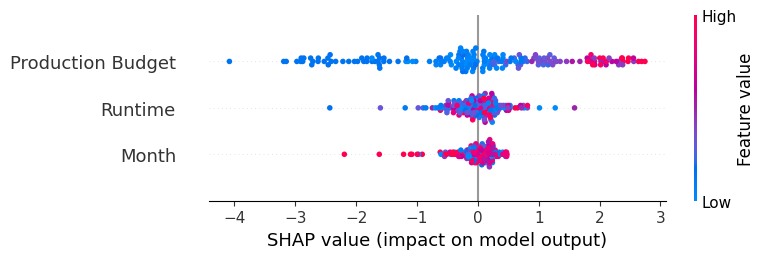

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [26]:
#Conclusions 
#If we have all the information, then the Domestic Revenue matters more than anything else
#If the movie just came out, then the opening weekend amount matters more than anything else
#If the movie asn't released yet, then the production budget is the best indicator. 